In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)  

In [3]:
# Generate input data (x-values)
num_samples = 1000
x = np.linspace(0, 2*np.pi - 1e-6, num_samples)[:, np.newaxis]  # Small epsilon to avoid floating-point precision issues
np.random.shuffle(x)
x_train, x_test, x_valid = x[:800, :], x[800:900, :], x[900:, :]

# Generate target sine values (y-values)
y_train = tf.math.sin(x_train)
y_test = tf.math.sin(x_test)
y_valid = tf.math.sin(x_valid)

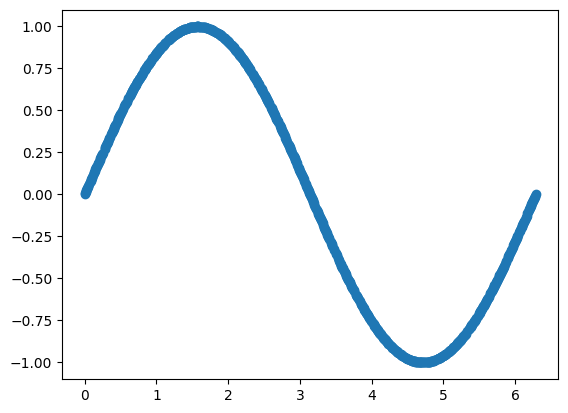

In [4]:
# plt.figure(figsize=(8, 6))
# plt.plot(x_train, y_train, label='Sine Wave', color='b')
# plt.title('Sine Wave')
# plt.xlabel('x')
# plt.ylabel('sin(x)')
# #plt.grid(True)
# plt.legend()
# plt.show()
plt.plot(x_train, y_train, 'o', label="Training data")
plt.legend()
plt.show()

In [242]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    print("FUCKKKKKKK\t", w.shape)
    qml.RY(w[0], wires=0)
    qml.RY(w[1], wires=1)
    qml.RY(w[2], wires=2)
    qml.RY(w[3], wires=3)
    # for idx, element in enumerate(w):
    #     qml.RY(element, wires=idx)
    # def single_ry(element, idx):
    #     return qml.RY(element, wires=idx)
    # tf.map_fn(single_ry, elems=[w, tf.range(tf.shape(w)[0])], dtype=tf.float32)
def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [243]:
dev = qml.device("default.qubit", wires=4)

In [248]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = tf.reshape(q_weights_flat, (6,4))
    print("MUM\t", q_weights.shape)
    #q_weights = q_weights_flat.reshape(6, 4)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(4)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    # def func(q_weight):
    #     # print("INJA\t", q_weight)
    #     entangling_layer(4)
    #     RY_layer(q_weight)

    entangling_layer(4)
    RY_layer(q_weights[0])

    entangling_layer(4)
    RY_layer(q_weights[1])

    entangling_layer(4)
    RY_layer(q_weights[2])

    entangling_layer(4)
    RY_layer(q_weights[3])

    entangling_layer(4)
    RY_layer(q_weights[4])

    entangling_layer(4)
    RY_layer(q_weights[5])

    # func(q_weights[0])
    # tf.map_fn(fn=lambda x: func(x), elems=q_weights, dtype=tf.float32)
    # for k in range(6):
    #     entangling_layer(4)
    #     RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(4)]
    return tuple(exp_vals)

In [258]:
# model = keras.Sequential([
#   keras.layers.Flatten(),
#   keras.layers.Dense(10, activation="relu"),  # Input layer and hidden layer with ReLU
#   keras.layers.Dense(1)  # Output layer
# ])

# model.compile(loss="mse", optimizer="adam")

class Net(tf.keras.Model):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = keras.layers.Dense(128, activation='relu')
        self.hidden2 = keras.layers.Dense(256, activation='relu')
        self.hidden3 = keras.layers.Dense(128, activation='relu')
        self.convertor = keras.layers.Dense(4, activation='relu')
        self.q_params = tf.Variable(0.01 * tf.random.normal([6 * 4]))
        self.output_layer = keras.layers.Dense(1)

    def call(self, x):
        x = self.hidden(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.convertor(x)
        # x = tf.map_fn(fn=lambda x: quantum_net(x, self.q_params), elems=x, dtype=tf.float32)
        q_out = tf.zeros((0, 4), dtype=tf.float64)
        # for elem in x:
        print("OPOPOPOPO\t",x.shape)
        q_out_elem = tf.concat([quantum_net(x[0], self.q_params)], axis=1)
        q_out = tf.concat([q_out, tf.expand_dims(q_out_elem, axis=0)], axis=0)

        q_out_elem = tf.concat([quantum_net(x[1], self.q_params)], axis=1)
        q_out = tf.concat([q_out, tf.expand_dims(q_out_elem, axis=0)], axis=0)

        q_out_elem = tf.concat([quantum_net(x[2], self.q_params)], axis=1)
        q_out = tf.concat([q_out, tf.expand_dims(q_out_elem, axis=0)], axis=0)

        q_out_elem = tf.concat([quantum_net(x[3], self.q_params)], axis=1)
        q_out = tf.concat([q_out, tf.expand_dims(q_out_elem, axis=0)], axis=0)

        x = self.output_layer(x)
        return x

In [259]:
model = Net()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=["accuracy"],)

In [260]:
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=40, verbose=2)  # Train for 100 epochs

Epoch 1/40
OPOPOPOPO	 (32, 4)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
OPOPOPOPO	 (32, 4)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKK

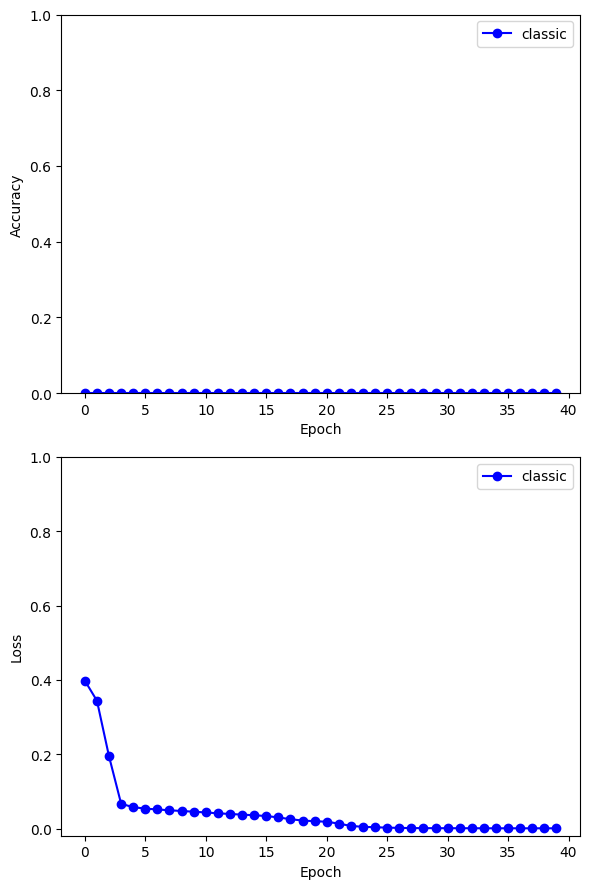

In [261]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(history.history["val_accuracy"], "-ob", label="classic")
#ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(history.history["val_loss"], "-ob", label="classic")
#ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=1)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

OPOPOPOPO	 (32, 4)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
1/4 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/stepOPOPOPOPO	 (None, 4)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6, 4)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
FUCKKKKKKK	 (4,)
MUM	 (6

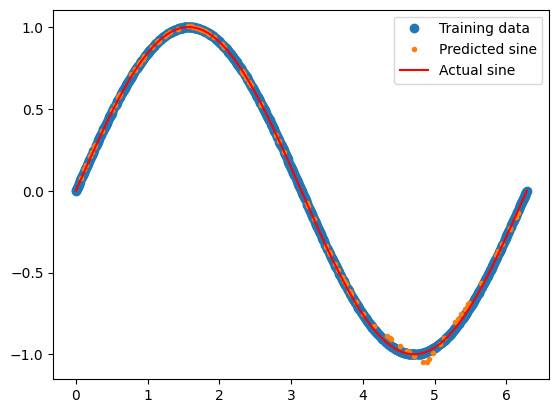

In [262]:
# #x_new = tf.linspace(-2*np.pi, 2*np.pi , 100)[:, np.newaxis]
x_new = np.linspace(0, 2 * np.pi, 100)
# #y = np.sin(x) + 0.5 * np.random.randn(len(x))
y_predicted = model.predict(x_test)

plt.plot(x_train, y_train, 'o', label="Training data")
plt.plot(x_test, y_predicted, '.', label="Predicted sine")
plt.plot(x_new, np.sin(x_new), 'r', label="Actual sine")
plt.legend()
plt.show()

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Flatten

model2 = Sequential()
#model2.add(Flatten())
model2.add(Dense(100))
model2.add(LeakyReLU(alpha=0.03))
model2.add(Dense(100))
model2.add(LeakyReLU(alpha=0.03))
model2.add(Dense(1))

In [54]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=["accuracy"],)

In [55]:
history2 = model2.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=80, verbose=2)  # Train for 100 epochs

Epoch 1/80
25/25 - 2s - 83ms/step - accuracy: 0.0012 - loss: 0.4223 - val_accuracy: 0.0000e+00 - val_loss: 0.3242
Epoch 2/80
25/25 - 0s - 5ms/step - accuracy: 0.0012 - loss: 0.3236 - val_accuracy: 0.0000e+00 - val_loss: 0.2530
Epoch 3/80
25/25 - 0s - 5ms/step - accuracy: 0.0012 - loss: 0.2440 - val_accuracy: 0.0000e+00 - val_loss: 0.1749
Epoch 4/80
25/25 - 0s - 7ms/step - accuracy: 0.0012 - loss: 0.1802 - val_accuracy: 0.0000e+00 - val_loss: 0.1385
Epoch 5/80
25/25 - 0s - 5ms/step - accuracy: 0.0000e+00 - loss: 0.1585 - val_accuracy: 0.0000e+00 - val_loss: 0.1326
Epoch 6/80
25/25 - 0s - 5ms/step - accuracy: 0.0000e+00 - loss: 0.1502 - val_accuracy: 0.0000e+00 - val_loss: 0.1233
Epoch 7/80
25/25 - 0s - 6ms/step - accuracy: 0.0012 - loss: 0.1395 - val_accuracy: 0.0000e+00 - val_loss: 0.1142
Epoch 8/80
25/25 - 0s - 6ms/step - accuracy: 0.0012 - loss: 0.1313 - val_accuracy: 0.0000e+00 - val_loss: 0.1077
Epoch 9/80
25/25 - 0s - 6ms/step - accuracy: 0.0012 - loss: 0.1264 - val_accuracy: 0.00

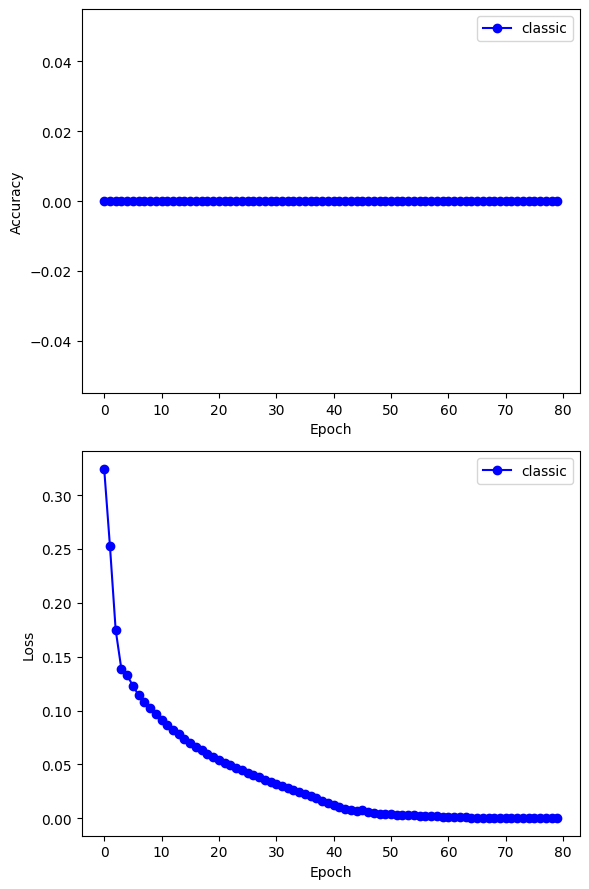

In [56]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(history2.history["val_accuracy"], "-ob", label="classic")
#ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
#ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(history2.history["val_loss"], "-ob", label="classic")
#ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
#ax2.set_ylim(top=1)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


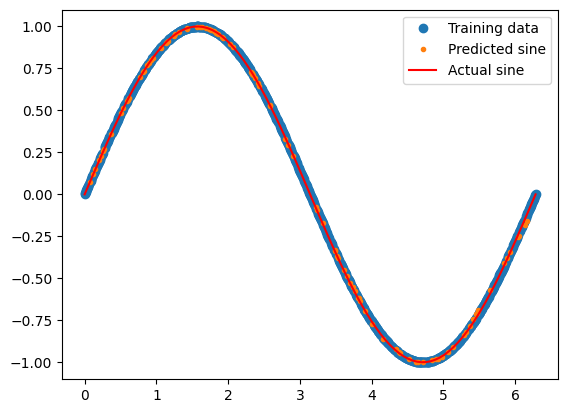

In [57]:
# #x_new = tf.linspace(-2*np.pi, 2*np.pi , 100)[:, np.newaxis]
x_new = np.linspace(0, 2 * np.pi, 100)
# #y = np.sin(x) + 0.5 * np.random.randn(len(x))
y_predicted = model2.predict(x_test)

plt.plot(x_train, y_train, 'o', label="Training data")
plt.plot(x_test, y_predicted, '.', label="Predicted sine")
plt.plot(x_new, np.sin(x_new), 'r', label="Actual sine")
plt.legend()
plt.show()

In [90]:
from tensorflow.keras.layers import LSTM

# model3 = Sequential()
# #model3.add(Flatten())
# model3.add(Conv1D(100, 3, strides=1, input_shape=(40, 1)))
# model3.add(LeakyReLU(alpha=0.03))
# model3.add(Conv1D(100, 3, strides=1))
# model3.add(LeakyReLU(alpha=0.03))
# model3.add(Flatten())
# model3.add(Dense(100))
# model3.add(LeakyReLU(alpha=0.03))
# model3.add(Dense(1))

model3 = Sequential()
model3.add(LSTM(100, return_sequences=True, stateful=True))
model3.add(LSTM(100, return_sequences=False, stateful=True))
model3.add(Dense(1))

In [91]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=["accuracy"],)

In [92]:
# x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
# x_train_cnn.shape

In [93]:
# x_valid_cnn = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], 1)
# x_valid_cnn.shape

In [95]:
history3 = model3.fit(x_train_cnn, y_train, validation_data=(x_valid_cnn, y_valid), epochs=40, batch_size=1, verbose=2)  # Train for 100 epochs

Epoch 1/40
800/800 - 5s - 6ms/step - accuracy: 0.0000e+00 - loss: 0.2329 - val_accuracy: 0.0000e+00 - val_loss: 0.1946
Epoch 2/40
800/800 - 3s - 4ms/step - accuracy: 0.0000e+00 - loss: 0.1502 - val_accuracy: 0.0000e+00 - val_loss: 0.0784
Epoch 3/40
800/800 - 3s - 3ms/step - accuracy: 0.0012 - loss: 0.0669 - val_accuracy: 0.0000e+00 - val_loss: 0.0408
Epoch 4/40
800/800 - 3s - 3ms/step - accuracy: 0.0012 - loss: 0.0309 - val_accuracy: 0.0000e+00 - val_loss: 0.0165
Epoch 5/40
800/800 - 3s - 4ms/step - accuracy: 0.0012 - loss: 0.0199 - val_accuracy: 0.0000e+00 - val_loss: 0.0099
Epoch 6/40
800/800 - 3s - 3ms/step - accuracy: 0.0012 - loss: 0.0130 - val_accuracy: 0.0000e+00 - val_loss: 0.0170
Epoch 7/40
800/800 - 5s - 7ms/step - accuracy: 0.0012 - loss: 0.0129 - val_accuracy: 0.0000e+00 - val_loss: 0.0212
Epoch 8/40
800/800 - 3s - 3ms/step - accuracy: 0.0012 - loss: 0.0115 - val_accuracy: 0.0000e+00 - val_loss: 0.0257
Epoch 9/40
800/800 - 3s - 3ms/step - accuracy: 0.0012 - loss: 0.0104 - v

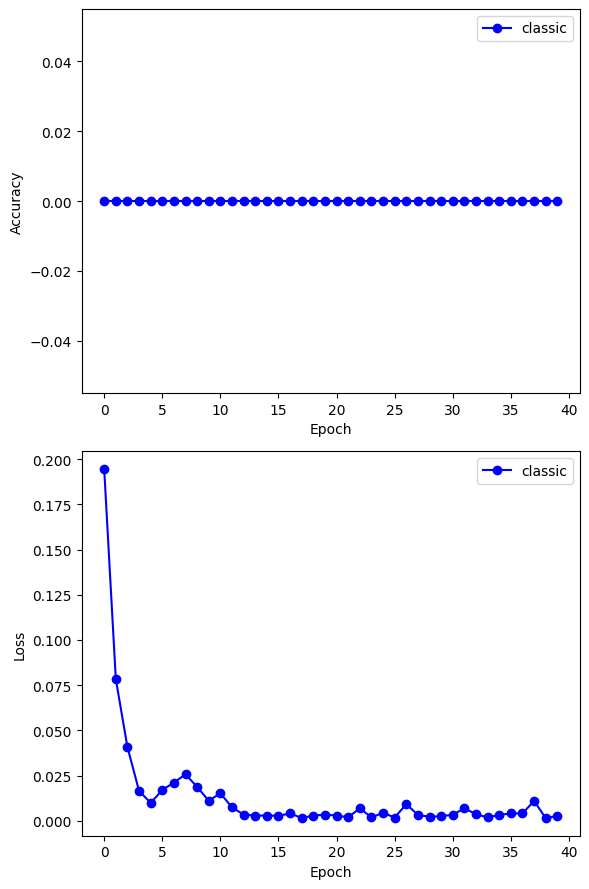

In [96]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(history3.history["val_accuracy"], "-ob", label="classic")
#ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
#ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(history3.history["val_loss"], "-ob", label="classic")
#ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
#ax2.set_ylim(top=1)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

In [103]:
# #x_new = tf.linspace(-2*np.pi, 2*np.pi , 100)[:, np.newaxis]
x_new = np.linspace(0, 2 * np.pi, 100)
# #y = np.sin(x) + 0.5 * np.random.randn(len(x))
#x_test_cnn = x_new.reshape(100, 1, 1)
y_predicted = model3.predict(x_test.reshape(100, 1, 1))

plt.plot(x_train, y_train, 'o', label="Training data")
plt.plot(x_test, y_predicted, '.', label="Predicted sine")
plt.plot(x_new, np.sin(x_new), 'r', label="Actual sine")
plt.legend()
plt.show()

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step

InvalidArgumentError: Graph execution error:

Detected at node sequential_22_1/lstm_1_1/while/lstm_cell_1/add defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 608, in run_forever

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\asyncio\events.py", line 84, in _run

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\dehgh\AppData\Local\Temp\ipykernel_5388\2695603706.py", line 5, in <module>

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 508, in predict

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 208, in one_step_on_data_distributed

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 198, in one_step_on_data

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 96, in predict_step

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\models\sequential.py", line 209, in call

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\models\functional.py", line 556, in call

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\layers\rnn\lstm.py", line 570, in call

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\layers\rnn\rnn.py", line 406, in call

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\layers\rnn\lstm.py", line 565, in inner_loop

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\layers\rnn\rnn.py", line 346, in inner_loop

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\backend\tensorflow\rnn.py", line 428, in rnn

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\backend\tensorflow\rnn.py", line 411, in _step

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\layers\rnn\rnn.py", line 338, in step

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\layers\layer.py", line 882, in __call__

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\dehgh\Documents\windows-projects\final\Lib\site-packages\keras\src\layers\rnn\lstm.py", line 266, in call

Incompatible shapes: [4,400] vs. [32,400]
	 [[{{node sequential_22_1/lstm_1_1/while/lstm_cell_1/add}}]] [Op:__inference_one_step_on_data_distributed_125227]

In [102]:
x_test.shape

(100, 1)